```yaml
---
jupytext:
  text_representation:
    extension: .md
    format_name: myst
    format_version: 0.13
    jupytext_version: 1.14.4
kernelspec:
  display_name: Python 3 (ipykernel)
  language: python
  name: python3
---
```

# Evaluate Regression

These 2 plots allow you to visualize your learning's accuracy.

In [28]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.api import het_goldfeldquandt
from statsmodels.compat import lzip
from statsmodels.formula.api import ols
import numpy as np
from sklearn_evaluation import plot

## Fetch Data

In [29]:
X, y = load_diabetes(return_X_y=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Conduct Learning

In [31]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = reg.predict(X_test)
y_true = y_test

## Visualize Evaluations

### Residuals Plot

This plot shows the residual values' distribution against the predicted value.

<Axes: title={'center': 'Residuals Plot'}, xlabel='Predicted Value', ylabel='Residuals'>

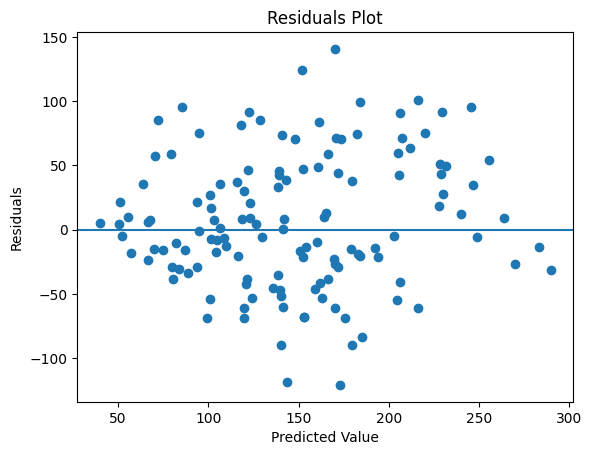

In [33]:
plot.residuals(y_true, y_pred)

### Prediction Error Plot

This plot has 2 lines: the identity line (where y_predicted=y_measured) and the best fit regression line of y_predicted against y_measured. The difference between the 2 lines visualizes the error of the prediction and trend of learning.

<Axes: title={'center': 'Prediction Error'}, xlabel='y_true', ylabel='y_pred'>

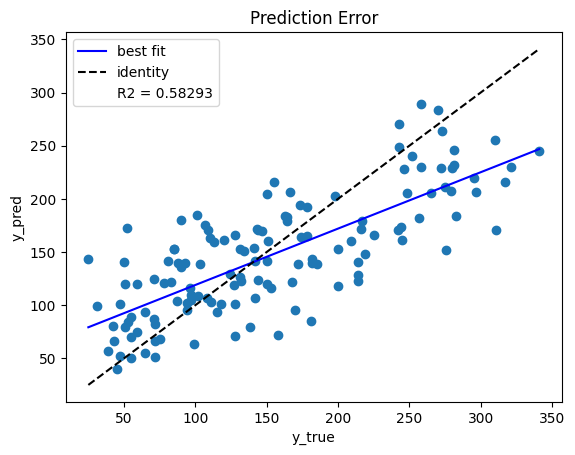

In [34]:
plot.prediction_error(y_true, y_pred)

### Cooks Distance

Cooks distance is an effective tool to measure the influence of an outlier in the training dataset for a regression problem. Outliers are data points that vary significantly from the rest of the data points in the training set. The presence of outliers in the training phase can affect the parameters that the model learns. This implementation assumes the Ordinary Least Squares (OLS) regression.

Create a dataset with strong outliers.

In [35]:
from sklearn.datasets import make_regression

X, y = make_regression(
    n_samples=100, n_features=6, n_informative=5, n_targets=1, bias=100.0, noise=30.0
)

<Axes: title={'center': "Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

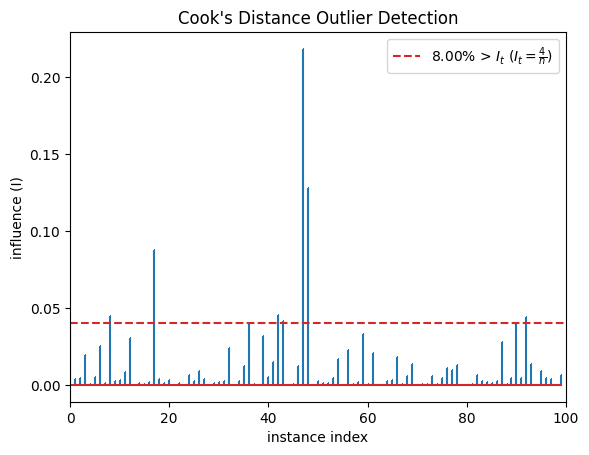

In [36]:
plot.cooks_distance(X, y)

## Heteroscedasticity in Regression

When discussing the residuals in regression analysis, we refer to heteroscedasticity, which is characterized by a systematic change in the spread of the residuals over the range of the observed values. The issue with heteroscedasticity is that it violates the assumption of Ordinary Least Squares (OLS) regression that all residuals originate from a population with a uniform variance (homoscedasticity). As noticed above in the Cook's Distance section, the presence of outliers or large range of values in the training data can be a contributing factor to heteroscedasticity.

### Detecting Heteroscedasticity

#### Residual Plot

First, create a Residuals Plot, using the same code provided [above](#residuals-plot).

<Axes: title={'center': 'Residuals Plot'}, xlabel='Predicted Value', ylabel='Residuals'>

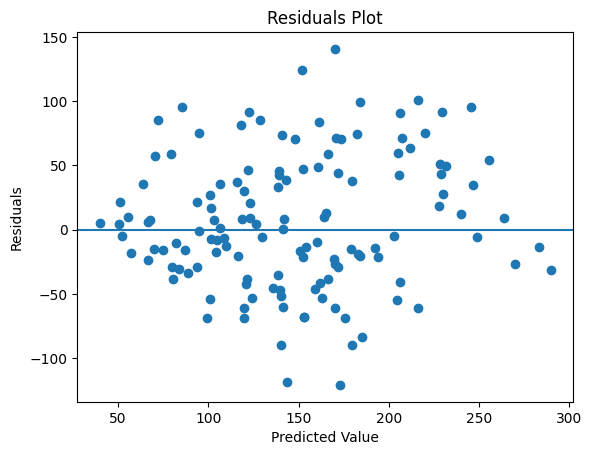

In [37]:
plot.residuals(y_true, y_pred)

Ideally, this plot should display random residuals (no patterns) that are uncorrelated and uniform. If you see patterns in the residuals, you might not be able to trust the results of your model. **Heteroscedasticity produces a distinctive fan or cone shape in residual plots.** In summary, the telltale pattern for heteroscedasticity is that as the predicted values on the x-axis increase, the variance of the residuals also increases. 

According to the above plot generated from the diabetes dataset, **the variance of residuals does have a minor fanning effect, which means that the residuals are close to 0 for small x values and are more spread out for large x values.** This is a sign of heteroscedasticity.

#### Breusch-Pagan Test

Instead of eye-balling residual plots to check for heteroscedasticity, we can obtain a concrete "yes" or "no" answer on the presence of heteroscedasticity in our model by formally conducting a Breusch-Pagan Test. Before conducting the test, we must initialize our linear regression model using the statsmodels package because sklearn's regression function is not compatible with statsmodels' Breusch-Pagan Test function. Since the data is already split into train and test tests, this step does not need to be repeated.

In [38]:
# Conduct Learning using the ols() function from statsmodel.formula.api

fit = ols(formula='y_train ~ X_train', data={'y_train': y_train, 'X_train': X_train}).fit()

The null hypothesis ($H_0$): Homoscedasticity is present.

The alternative hypothesis ($H_a$): Homoscedasticity is not present (i.e. heteroscedasticity exists)

In [39]:
# Perform the Breusch-Pagan test from statsmodels.stats.api

names = ['Lagrange Multiplier Statistic:', 'p-value of Lagrange Multiplier Statistic:',
        'F-statistic:', 'p-value of F-statistic:']
test = het_breuschpagan(fit.resid, fit.model.exog)

lzip(names, test)

[('Lagrange Multiplier Statistic:', 25.640484897463196),
 ('p-value of Lagrange Multiplier Statistic:', 0.0042550198987909675),
 ('F-statistic:', 2.696526529796996),
 ('p-value of F-statistic:', 0.0035346121498534525)]

**Because both p-values are less than 0.05 (5% alpha, $\alpha$, significance level), we reject the null hypothesis. Therefore, we have sufficient evidence to conclude that heteroscedasticity is present in the regression model.**

#### Goldfeld-Quant Test

To further reinforce or check the results of our Breusch-Pagan Test, we can conduct a Goldfeld-Quant Test that aids us the same way the Breusch-Pagan Test does. 

**Note: The Goldfeld-Quandt Test works by removing some number of observations located in the center of the dataset, then testing to see if the spread of residuals is different from the resulting two datasets that are on either side of the central observations.**

Typically we choose to remove around 20% of the total observations. In this case, we can use the drop argument to specify that we’d like to remove 20% of observations

The null hypothesis ($H_0$): Homoscedasticity is present (variance in the two sub-samples are the same).

The alternative hypothesis ($H_a$): Homoscedasticity is not present (i.e. heteroscedasticity exists or the variance in the second sample is larger than in the first, or decreasing or two-sided)

In [53]:
names = ['F-statistic:', 'p-value of F-statistic:',
        'Ordering:']
test = het_goldfeldquandt(y_train, X_train, drop=0.2)

lzip(names, test)

[('F-statistic:', 1.0778839880289313),
 ('p-value of F-statistic:', 0.35679297567355694),
 ('Ordering:', 'increasing')]

Wow! **The results from the Goldfeld-Quant Test differ from those of the Breusch-Pagan Test and that can be expected.** If they did not, then one could expect either test to be superseded based on several considerations, such as ease of computation etc. **Because the p-value is not less than 0.05 (5% alpha, $\alpha$, significance level), we fail to reject the null hypothesis. Therefore, we do not have sufficient evidence to conclude that heteroscedasticity is present in the regression model.** Let us now try to fix the heteroscedasticity issue!

### Variable Transformations to Fix Heteroscedasticity

One way to fix heteroscedasticity in the data is to transform either the independent variables (X) or the dependent variable (y). The following code shows how to use a Box-Cox transformation on the dependent variable, y, to fix heteroscedasticity. If the dependent variable has negative samples, we use a Yeo-Johnson transformation instead of a Box-Cox transformation. Note that the **Box-Cox transformation requires the dependent variable to be positive**.

In [63]:
# fetch data
X, y = load_diabetes(return_X_y=True)

# check for negative values in the dependent variable, y
y.min()

25.0

Because the minimum value of y is positive, we will use the Box-Cox transformation, which **requires y to be a 2D array as the input**. After reshaping, using `numpy`, each row represents a sample and each column represents a feature. In this case, y is being treated as a single feature with multiple samples, so it needs to be reshaped accordingly.

In [64]:
# transform y by reshaping first and then using the Box-Cox transformation
y_transformed = power_transform(y.reshape(-1, 1), method="box-cox")

In [65]:
# split the dataset again using the transformed y
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.3)

In [66]:
# fit the model
reg.fit(X_train, y_train)

LinearRegression()

In [67]:
# get predictions
y_pred = reg.predict(X_test)
y_true = y_test

<Axes: title={'center': 'Residuals Plot'}, xlabel='Predicted Value', ylabel='Residuals'>

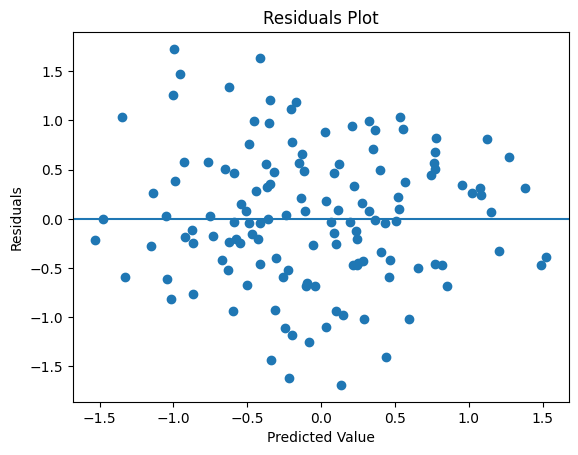

In [68]:
# plot the residuals
plot.residuals(y_true, y_pred)

From the above plot, the residuals are more random than those in the original residual plot. No fanning effect can be observed, as a result of the transformation on y. Also notice that, due to the transformation on y, the predicted values as well as the transformed y values are "squeezed" to fit between -2 and 2, helping eliminate or reduce heteroscedasticity in the model while conserving the overall structure of the data. To further reinforce our conclusion of the presence of heteroscedasticity, the aforementioned tutorials of the Breusch-Pagan and Goldfeld-Quant Tests can be conducted on the transformed y.

### Checking for Heteroscedasticity in the Transformed Data using the Breusch-Pagan Test and Goldfeld-Quant Test

#### Breusch-Pagan Test on Transformed Data

In [69]:
fit = ols(formula='y_train ~ X_train', data={'y_train': y_train, 'X_train': X_train}).fit()
names = ['Lagrange Multiplier Statistic:', 'p-value of Lagrange Multiplier Statistic:',
        'F-statistic:', 'p-value of F-statistic:']
test = het_breuschpagan(fit.resid, fit.model.exog)

lzip(names, test)

[('Lagrange Multiplier Statistic:', 11.74425740853517),
 ('p-value of Lagrange Multiplier Statistic:', 0.3025370109499585),
 ('F-statistic:', 1.1773662225101005),
 ('p-value of F-statistic:', 0.3055650632293408)]

The Breusch-Pagan Test is conducted on the transformed data, which is the same as the original data, except that the dependent variable, y, has been transformed using a Box-Cox transformation. The test's results are in agreement with those of the original data. Now, the moment of truth: will the Goldfeld-Quant Test agree with the Breusch-Pagan Test?

#### Goldfeld-Quant Test on Transformed Data

In [62]:
names = ['F-statistic:', 'p-value of F-statistic:',
        'Ordering:']
test = het_goldfeldquandt(y_train, X_train, drop=0.2)

lzip(names, test)

[('F-statistic:', 1.1214304763166945),
 ('p-value of F-statistic:', 0.28475311547420085),
 ('Ordering:', 'increasing')]

**Yes! The Goldfeld-Quant Test agrees with the Breusch-Pagan Test! This is a good sign that the Box-Cox transformation has fixed the heteroscedasticity issue in the data.**